#### Processamento de Big Data: Projeto Final

Licenciatura em Ciência de Dados

CDB1

Marco Delgado Esperança, Nº 110451

Maria João Ferreira Lourenço, Nº 104716

Docente: João Oliveira

8 de abril de 2023

Flight Status Prediction

https://www.kaggle.com/datasets/robikscube/flight-delay-dataset-20182022

# Visualização

Neste notebook procedemos à elaboração de diversos gráficos - gráficos de barras, histogramas, time series, gráficos circulares - sobre as variáveis presentes no ficheiro parquet criado, para podermos visualizar de forma mais intuitiva as variáveis e as relações entre elas.

In [2]:
from pyspark.shell import spark

23/04/04 18:35:18 WARN Utils: Your hostname, LAPTOP-SDIJI12J resolves to a loopback address: 127.0.1.1; using 172.20.49.164 instead (on interface eth0)
23/04/04 18:35:18 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


23/04/04 18:35:20 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
23/04/04 18:35:22 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.
Welcome to
      ____              __
     / __/__  ___ _____/ /__
    _\ \/ _ \/ _ `/ __/  '_/
   /__ / .__/\_,_/_/ /_/\_\   version 3.3.1
      /_/

Using Python version 3.10.6 (main, Nov 14 2022 16:10:14)
Spark context Web UI available at http://172.20.49.164:4041
Spark context available as 'sc' (master = local[*], app id = local-1680629722111).
SparkSession available as 'spark'.


In [3]:
spark.stop()

In [4]:
from pyspark.sql import SparkSession

spark=SparkSession.builder.appName("Graficos")\
      .config("spark.driver.memory", "128g")\
      .config("spark.executor.memory", "64g")\
      .config("spark.driver.host", "127.0.0.1")\
      .getOrCreate()

23/04/04 18:35:23 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.


In [5]:
# Some general imports 

import os
import sys

import numpy as np 
import pandas as pd  
import matplotlib.pyplot as plt
import seaborn as sns
from pyspark.sql.functions import desc
from pyspark.sql import SparkSession
import pyspark.sql.functions as F
from pyspark import SparkConf, SparkContext
from pyspark.sql.functions import count, avg
# from ydata_profiling import ProfileReport
import warnings
warnings.filterwarnings("ignore")

## Importação do ficheiro parquet

In [6]:
filename = ["./flights_clean.parquet"]
filename_s3 = "s3://pbdmybucketgrupo3/flights_clean.parquet/"

In [7]:
df_flights_clean = spark.read.format("parquet").load(filename_s3)

In [8]:
df_flights_clean.columns

['FlightDate',
 'Airline',
 'Origin',
 'Dest',
 'Cancelled',
 'Diverted',
 'CRSDepTime',
 'DepTime',
 'DepDelayMinutes',
 'DepDelay',
 'ArrTime',
 'ArrDelayMinutes',
 'AirTime',
 'CRSElapsedTime',
 'ActualElapsedTime',
 'Distance',
 'Year',
 'Quarter',
 'Month',
 'DayofMonth',
 'DayOfWeek',
 'Marketing_Airline_Network',
 'Operated_or_Branded_Code_Share_Partners',
 'DOT_ID_Marketing_Airline',
 'IATA_Code_Marketing_Airline',
 'Flight_Number_Marketing_Airline',
 'Operating_Airline',
 'IATA_Code_Operating_Airline',
 'Tail_Number',
 'OriginAirportID',
 'OriginAirportSeqID',
 'OriginCityName',
 'OriginState',
 'OriginStateName',
 'DestAirportID',
 'DestAirportSeqID',
 'DestCityName',
 'DestState',
 'DestStateName',
 'DepDel15',
 'DepartureDelayGroups',
 'DepTimeBlk',
 'WheelsOff',
 'WheelsOn',
 'ArrDelay',
 'ArrDel15',
 'ArrTimeBlk']

## Alguns dataframes mais pequenos que vão ser utilizados e funções de visualização

In [9]:
# arrival delay
df_arrdel15 = df_flights_clean.filter(df_flights_clean.ArrDel15 == 1)

In [10]:
# departure delay
df_del_dep = df_flights_clean.filter(df_flights_clean.DepDel15 == 1)

In [11]:
import seaborn as sns
import matplotlib.pyplot as plt

def plotBar(df, xcol, ycol, huecol=None):
    sns.barplot(data=df, x=xcol, y=ycol, hue=huecol)

In [12]:
def plotHistogram(df, xcol, huecol=None):
    sns.histplot(data=df, x=xcol, hue=huecol, multiple="stack")

In [13]:
def plot(df, xcol, ycol):
    sns.lineplot(data=df, x=xcol, y=ycol)

In [14]:
def plotScatter(df, xcol, ycol, huecol=None):
    sns.scatterplot(data=df, x=xcol, y=ycol, hue=huecol)

In [15]:
def plotScatterMatrix(df, huecol=None):
    sns.pairplot(data=df, hue=huecol)

## Gráfico de barras com o número de voos por ano

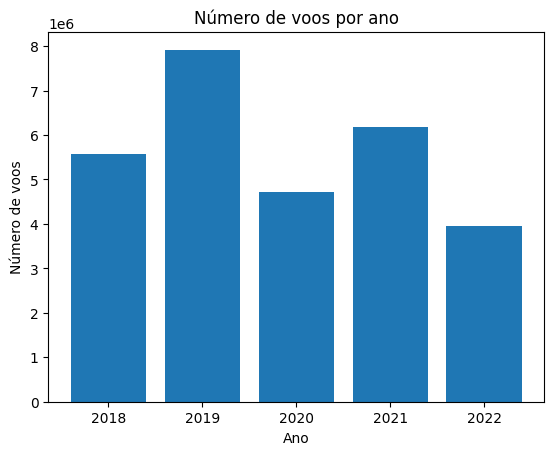

In [16]:
df_year_counts = df_flights_clean.groupBy('Year').agg(count('*').alias('num_flights'))


df_year_counts = df_year_counts.toPandas()


plt.bar(df_year_counts['Year'], df_year_counts['num_flights'])
plt.xlabel('Ano')
plt.ylabel('Número de voos')
plt.title('Número de voos por ano')
plt.show()

O ano com mais voos é 2019, em 2020 houve um grande decréscimo, que se deveu à pandemia e consequente fecho de fronteiras, em 2021, houve uma abertura ainda com restrições, mas fez com que aumentasse o número de voos. 2022 é o ano com menos voos, mas é de salientar que apenas temos dados até ao mês 7 - julho, o que vai influenciar todos os gráficos com as variáveis 'Year', 'Quarter', 'Month', 'DayofMonth', 'DayofWeek'.

## Gráfico de barras com o número de voos por trimestre

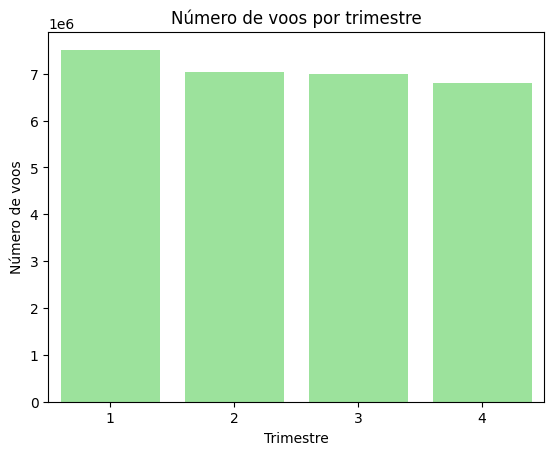

In [17]:
df_plot_quarter_flights = ( df_flights_clean
           .groupBy('Quarter')
           .agg(F.count('*').alias('Number of flights'))
           .sort('Quarter')
           .toPandas()
          )

sns.barplot(x='Quarter', y='Number of flights', data=df_plot_quarter_flights , order=df_plot_quarter_flights ['Quarter'], color='lightgreen')
plt.xlabel('Trimestre')
plt.ylabel('Número de voos')
plt.title('Número de voos por trimestre')
plt.show()

O trimestre com mais voos é o primeiro e o com menos o quarto. O segundo e terceiro trimestre não variam muito entre si.

## Time series com a evolução do número de voos por trimestre

In [18]:
sns.set(rc={'figure.figsize':(15,6)})

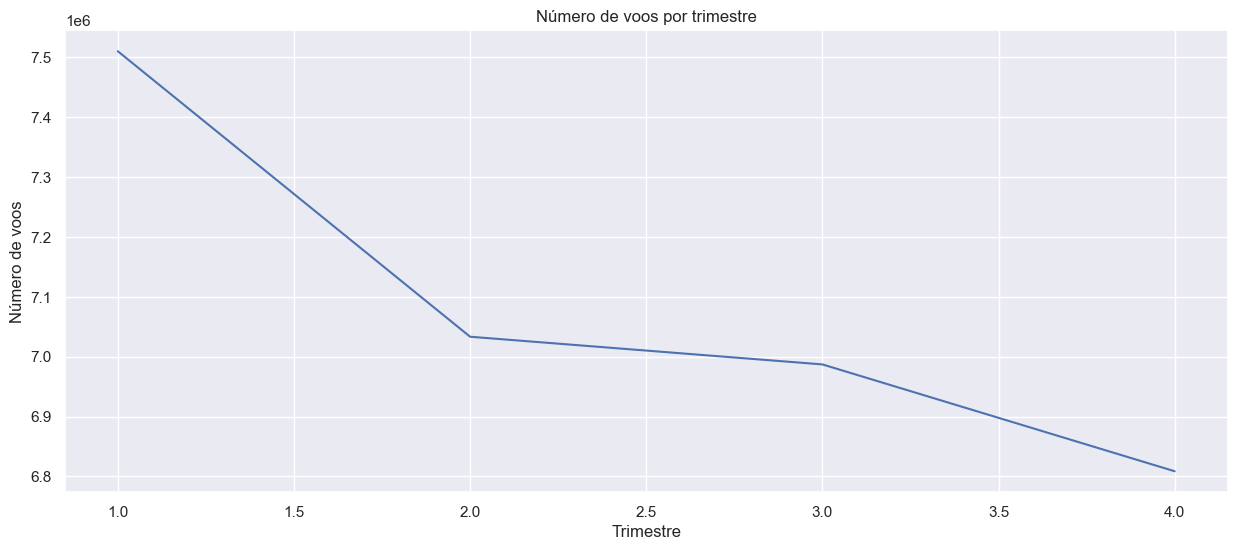

In [19]:
sns.lineplot(x='Quarter', y='Number of flights', data=df_plot_quarter_flights)
plt.xlabel('Trimestre')
plt.ylabel('Número de voos')
plt.title('Número de voos por trimestre')
plt.show()

O número de voos por trimestre cai a pique até ao segundo trimestre, decresce suavemente até ao terceiro e volta-se a registar uma descida significativa até ao quarto trimestre.

## Gráfico de barras com o número de voos por mês

In [20]:
sns.reset_defaults()

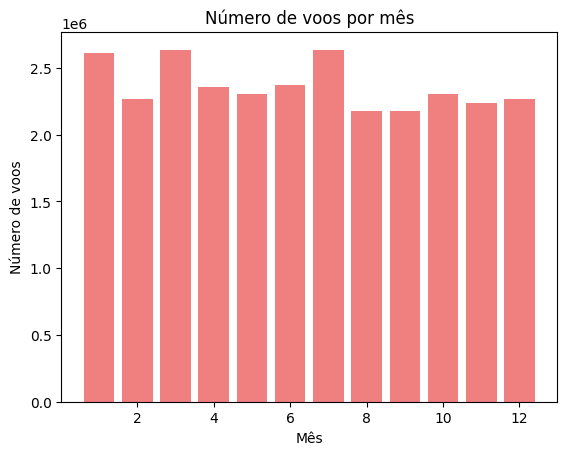

In [18]:
df_month_counts = df_flights_clean.groupBy('Month').agg(count('*').alias('num_flights'))

df_month_counts = df_month_counts.toPandas()

plt.bar(df_month_counts['Month'], df_month_counts['num_flights'], color='lightcoral')
plt.xlabel('Mês')
plt.ylabel('Número de voos')
plt.title('Número de voos por mês')
plt.show()

Os meses com mais voos são janeiro - 1 -, março - 3 - e julho - 7. Os meses com menos voos são agosto - 8 - e setembro - 9.

## Gráfico de barras com o número de voos por dia do mês

In [21]:
sns.set(rc={'figure.figsize':(15,6)})

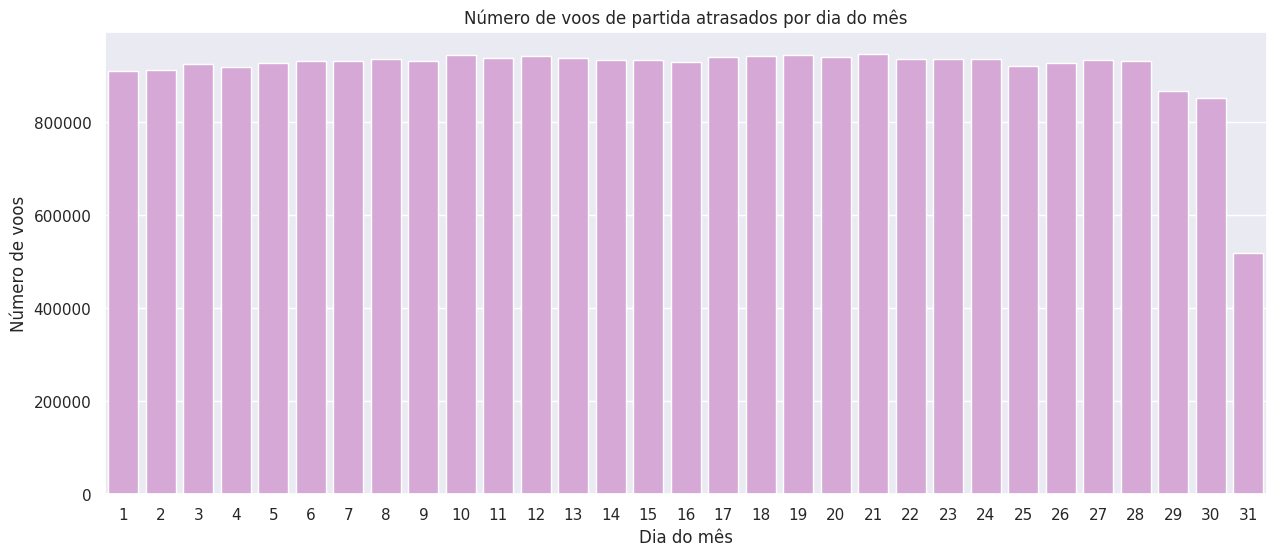

In [22]:
df_day_counts = df_flights_clean.groupBy('DayofMonth').agg(count('*').alias('Number of flights'))


df_day_counts = df_day_counts.toPandas()


ordered_days = df_day_counts.sort_values('DayofMonth')['DayofMonth'].values

# Plot a bar chart of the number of flights by day of the month
sns.barplot(x='DayofMonth', y='Number of flights', data=df_day_counts, order=ordered_days, color='plum')
plt.xlabel('Dia do mês')
plt.ylabel('Número de voos')
plt.title('Número de voos de partida atrasados por dia do mês')
plt.show()

Os dias do mês têm relativamente o mesmo número de voos, sendo que os menores valores estão nos dias 1, 2, 4, 25, 29, 30 e 31. Os dias com mais voos aparentam ser o dia 10 e 21. É de notar que o dia 31 é o dia com menos voos, pois é um dia que não existe em todos os meses, existindo apenas em janeiro, março, maio, julho, agosto, outubro e dezembro.

## Time series com a evolução número de voos por dia do mês

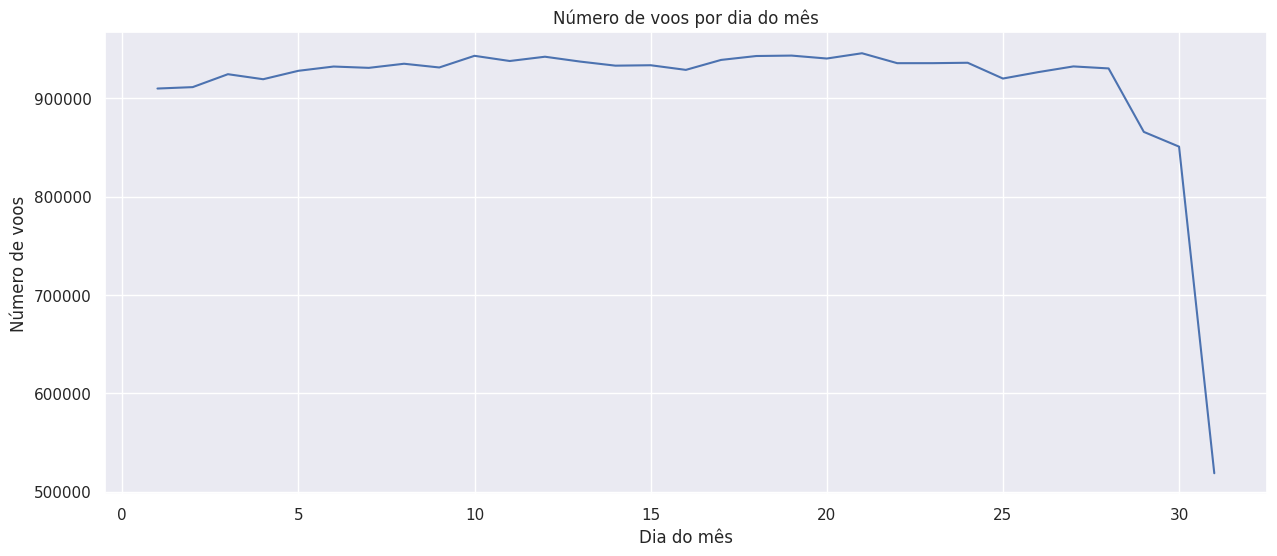

In [23]:
sns.lineplot(x='DayofMonth', y='Number of flights', data=df_day_counts)
plt.xlabel('Dia do mês')
plt.ylabel('Número de voos')
plt.title('Número de voos por dia do mês')
sns.set(rc={'figure.figsize':(15,6)})
plt.show()

Verifica-se que vai aumentando gradualmente desde o início do mês, até um ponto onde estabeliza relativamente e no final do mês verifica-se uma queda abrupta.

## Gráfico de barras com o número de voos por dia da semana

In [25]:
sns.reset_defaults()

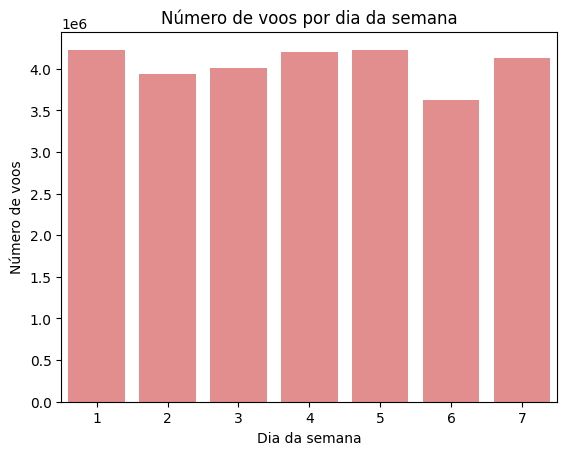

In [26]:
df_flights_by_day_week = ( df_flights_clean
           .groupBy('DayofWeek')
           .agg(F.count('*').alias('Number of flights'))
           .sort('DayofWeek')
           .toPandas()
          )

sns.barplot(x='DayofWeek', y='Number of flights', data=df_flights_by_day_week, order=df_flights_by_day_week['DayofWeek'], color='lightcoral')
plt.xlabel('Dia da semana')
plt.ylabel('Número de voos')
plt.title('Número de voos por dia da semana')
plt.show()

Os dias da semana com mais voos são 1, 4 e 5 e o com menos voos é 6.

## Time series com a evolução do número de voos por dia da semana

In [27]:
sns.set(rc={'figure.figsize':(15,6)})

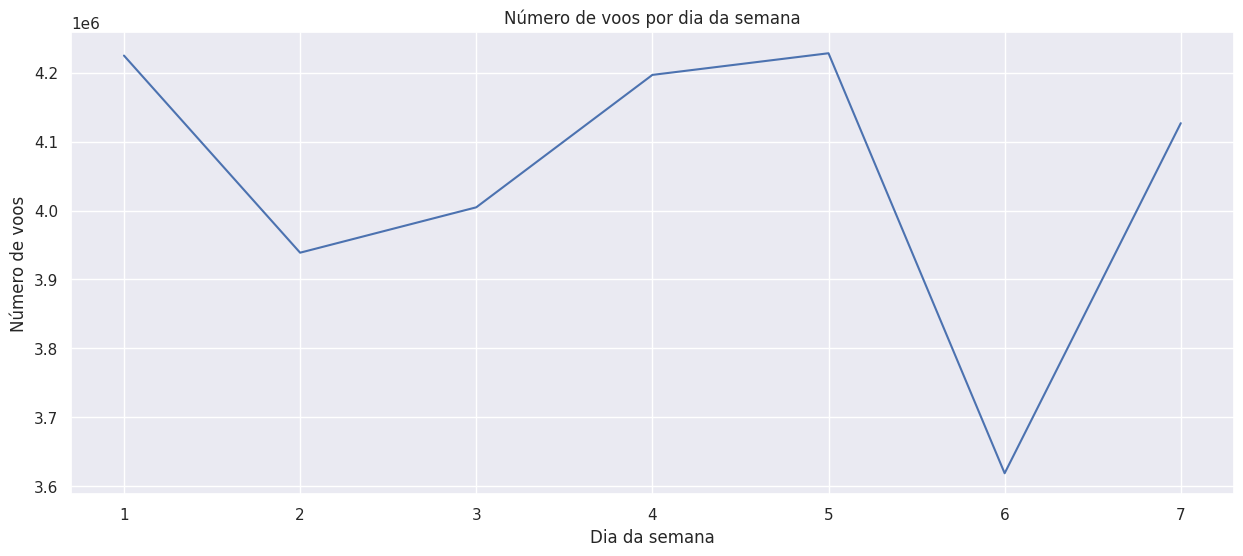

In [28]:
sns.lineplot(x='DayofWeek', y='Number of flights', data=df_flights_by_day_week)
plt.xlabel('Dia da semana')
plt.ylabel('Número de voos')
plt.title('Número de voos por dia da semana')
plt.show()

Os voos no dia da semana 2 caem a pique comparando com os voos em 1, depois crescem gradualmente até 5, caem abruptamente em 6 e voltam a aumentar em 7.

# -----

# Voos atrasados na partida

## Gráfico de barras com os voos atrasados na partida por ano

In [29]:
sns.reset_defaults()

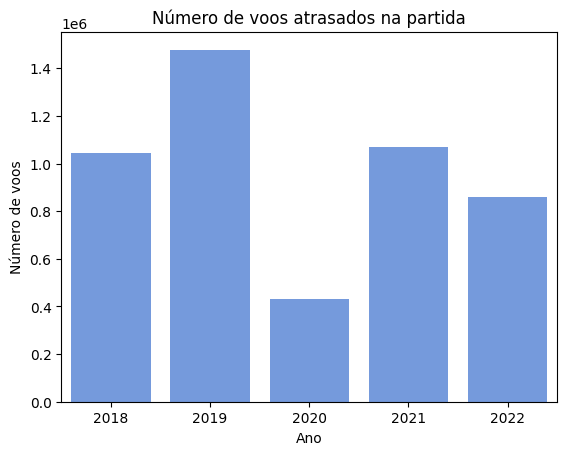

In [31]:
df_plot1 = ( df_del_dep
           .groupBy('Year')
           .agg(F.count('*').alias('Number of flights delayed'))
           .sort('Year')
           .toPandas()
          )

sns.barplot(x='Year', y='Number of flights delayed', data=df_plot1, order=df_plot1['Year'], color='cornflowerblue')
plt.xlabel('Ano')
plt.ylabel('Número de voos')
plt.title('Número de voos atrasados na partida')
plt.show()

O ano com mais voos atrasados na partida foi 2019 e o com menos foi 2020, o que corresponde ao ano com mais voos e ao segundo ano com menos voos.

## Gráfico de barras com os voos atrasados na partida por trimestre

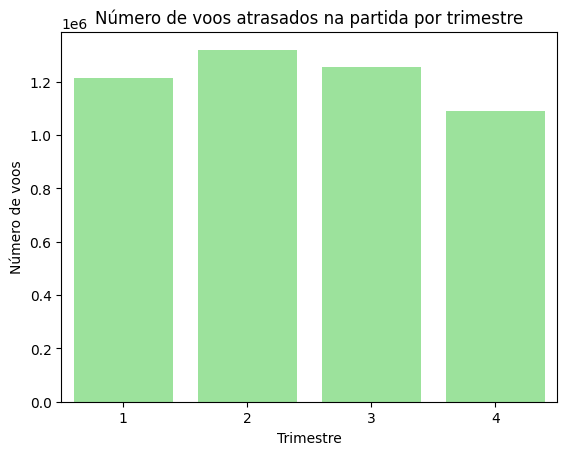

In [32]:
df_plot2 = ( df_del_dep
           .groupBy('Quarter')
           .agg(F.count('*').alias('Number of flights delayed'))
           .sort('Quarter')
           .toPandas()
          )

sns.barplot(x='Quarter', y='Number of flights delayed', data=df_plot2, order=df_plot2['Quarter'], color='lightgreen')
plt.xlabel('Trimestre')
plt.ylabel('Número de voos')
plt.title('Número de voos atrasados na partida por trimestre')
plt.show()

O trimestre com voos mais atrasados na partida é o segundo e o com menos atrasos é o quarto.

## Gráfico de barras com os voos atrasados na partida por mês

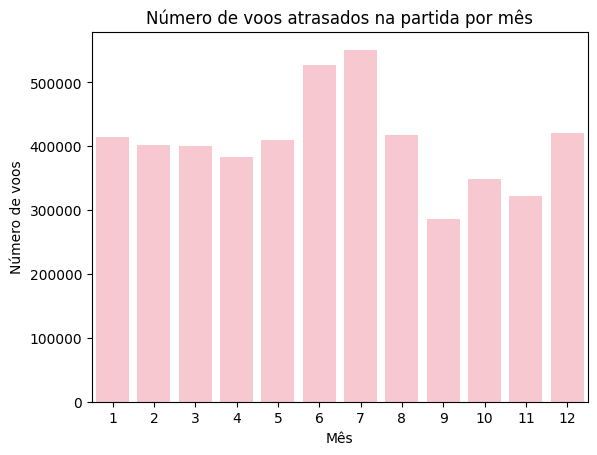

In [33]:
df_plot3 = ( df_del_dep
           .groupBy('Month')
           .agg(F.count('*').alias('Number of flights delayed'))
           .sort('Month')
           .toPandas()
          )

sns.barplot(x='Month', y='Number of flights delayed', data=df_plot3, order=df_plot3['Month'], color='pink')
plt.xlabel('Mês')
plt.ylabel('Número de voos')
plt.title('Número de voos atrasados na partida por mês')
plt.show()

O mês com voos mais atrasados na partida é no mês 7 - julho -, seguido por junho - 6. O com menos atrasos é setembro - 9.

## Gráfico de barras com os voos atrasados na partida por dia do mês

In [34]:
sns.set(rc={'figure.figsize':(15,6)})

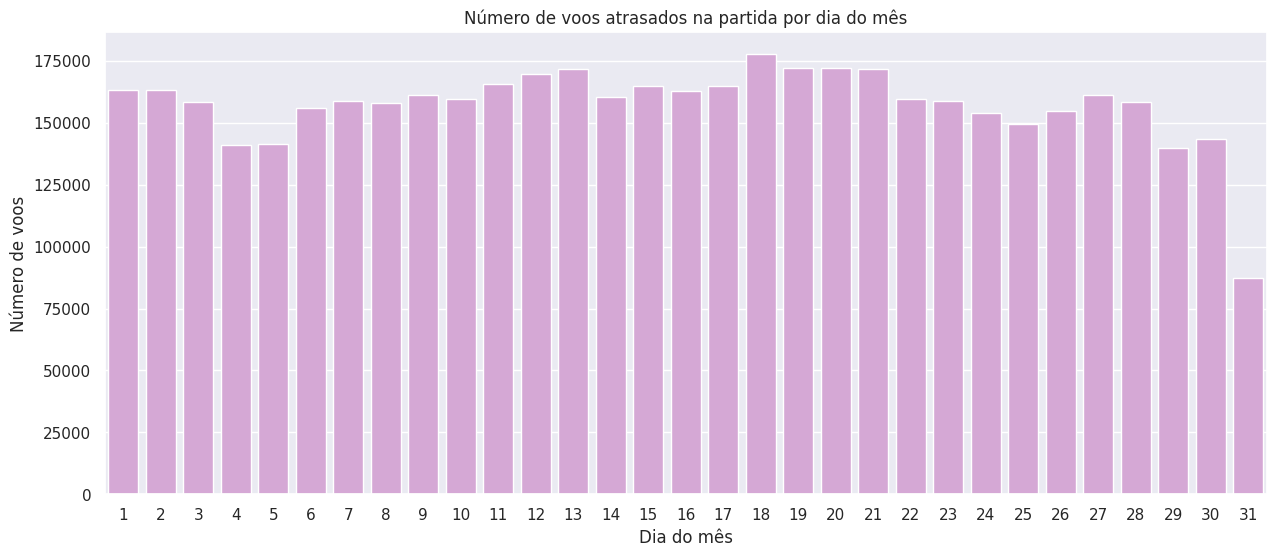

In [35]:
df_plot4 = ( df_del_dep
           .groupBy('DayofMonth')
           .agg(F.count('*').alias('Number of flights delayed'))
           .sort('DayofMonth')
           .toPandas()
          )

sns.barplot(x='DayofMonth', y='Number of flights delayed', data=df_plot4, order=df_plot4['DayofMonth'], color='plum')
plt.xlabel('Dia do mês')
plt.ylabel('Número de voos')
plt.title('Número de voos atrasados na partida por dia do mês')
sns.set(rc={'figure.figsize':(15,6)})
plt.show();

O dia do mês com voos mais atrsados na partida é 18 e o com menos é 31.

## Gráfico de barras com os voos atrasados na partida por dia da semana

In [36]:
sns.reset_defaults()

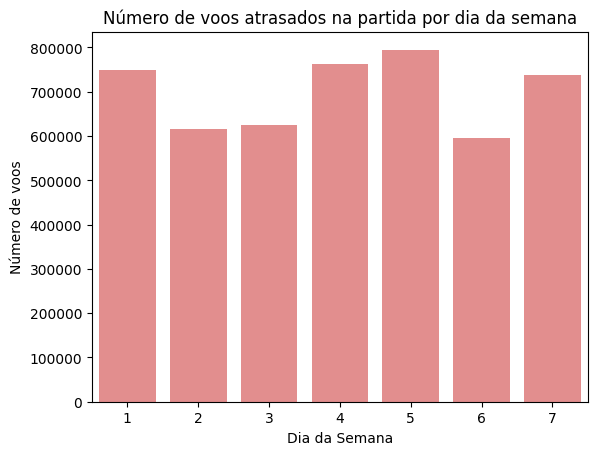

In [37]:
df_plot5 = ( df_del_dep
           .groupBy('DayofWeek')
           .agg(F.count('*').alias('Number of flights delayed'))
           .sort('DayofWeek')
           .toPandas()
          )

sns.barplot(x='DayofWeek', y='Number of flights delayed', data=df_plot5, order=df_plot5['DayofWeek'], color='lightcoral')
plt.xlabel('Dia da Semana')
plt.ylabel('Número de voos')
plt.title('Número de voos atrasados na partida por dia da semana')
plt.show()

O dia da semana com voos mais atrasados na partida é 5, seguido de 4, 1 e 7. O dia com menos voos atrasados é 6.

## Time series com a evolução do número de voos atrasados na partida por dia de semana

In [39]:
sns.set(rc={'figure.figsize':(15,6)})

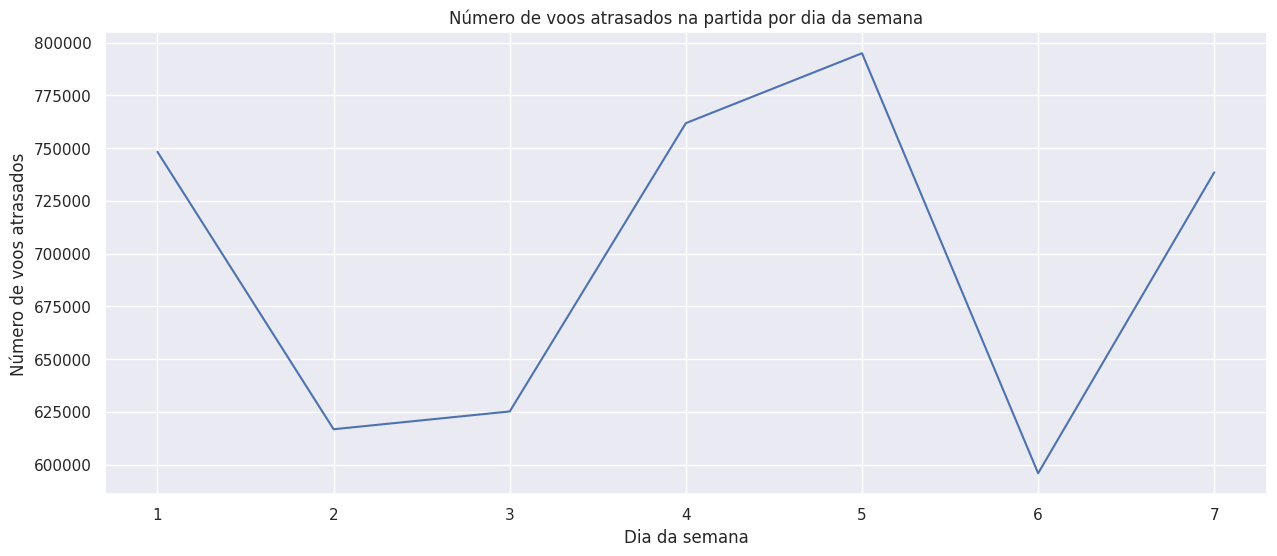

In [40]:
sns.lineplot(x='DayofWeek', y='Number of flights delayed', data=df_plot5)
plt.xlabel('Dia da semana')
plt.ylabel('Número de voos atrasados')
plt.title('Número de voos atrasados na partida por dia da semana')
plt.show()

O número de voos atrasados na partida, diminui significativamente no dia da semana 2 face a 1, aumenta ligeiramente até 3 e sobe muito até 5, caindo a pique em 6 e aumentando outra vez em 7.

## Gráfico circular com os voos atrasados na partida

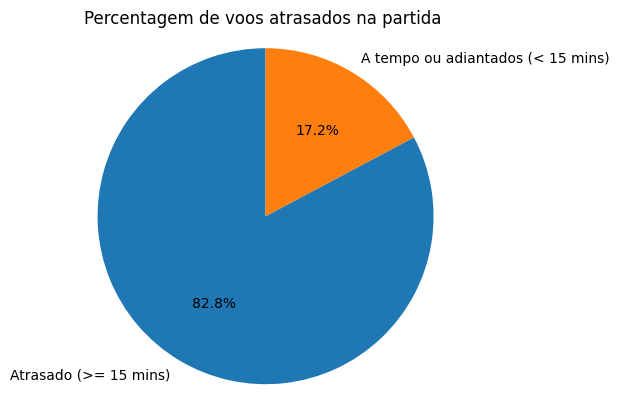

In [67]:
depdel15_counts = df_flights_clean.groupBy('DepDel15').count().collect()
counts = [row['count'] for row in depdel15_counts]
labels = ['Atrasado (>= 15 mins)', 'A tempo ou adiantados (< 15 mins)']
fig, ax = plt.subplots()

ax.pie(counts, labels=labels, autopct='%1.1f%%', startangle=90)
ax.axis('equal')
plt.title('Percentagem de voos atrasados na partida ')

# Show the plot
plt.show()

A percentagem de voos atrasados na partida é 82.8%, apenas 17.2%  estão a horas.

# -----

# Voos atrasados na chegada

## Gráfico de barras com os voos atrasados na chegada por ano

In [44]:
sns.reset_defaults()

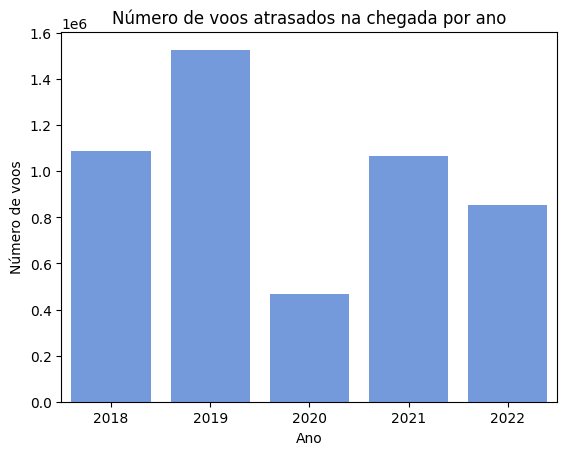

In [45]:
df_plot6 = ( df_arrdel15
           .groupBy('Year')
           .agg(F.count('*').alias('Number of flights delayed'))
           .sort('Year')
           .toPandas()
          )

sns.barplot(x='Year', y='Number of flights delayed', data=df_plot6, order=df_plot6['Year'], color='cornflowerblue')
plt.xlabel('Ano')
plt.ylabel('Número de voos')
plt.title('Número de voos atrasados na chegada por ano')
plt.show()

O ano com voos mais atrados na chegada á 2019 e com menos é 2020, tal como no gráfico correspondente para os voos atrasados na partida por ano.

## Gráfico de barras com os voos atrasados na chegada por trimestre

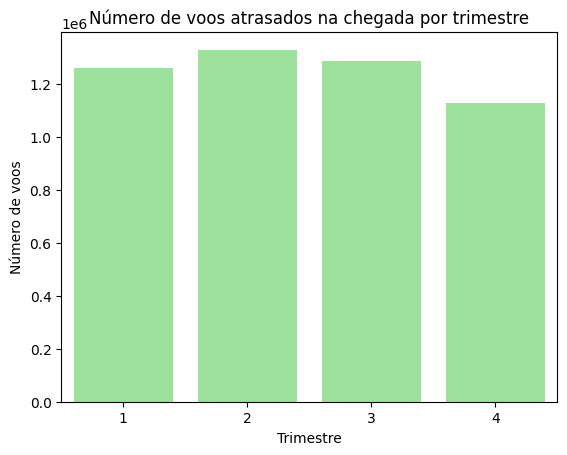

In [46]:
df_plot7 = ( df_arrdel15
           .groupBy('Quarter')
           .agg(F.count('*').alias('Number of flights delayed'))
           .sort('Quarter')
           .toPandas()
          )

sns.barplot(x='Quarter', y='Number of flights delayed', data=df_plot7, order=df_plot7['Quarter'], color='lightgreen')
plt.xlabel('Trimestre')
plt.ylabel('Número de voos')
plt.title('Número de voos atrasados na chegada por trimestre')
plt.show()

O trimestre com o maior número de voos atrasados na chegada é no segundo trimestre e o com menos é no quarto trimestre.

## Time series com a evolução do número de voos atrasados na chegada por trimestre

In [44]:
sns.set(rc={'figure.figsize':(10,6)})

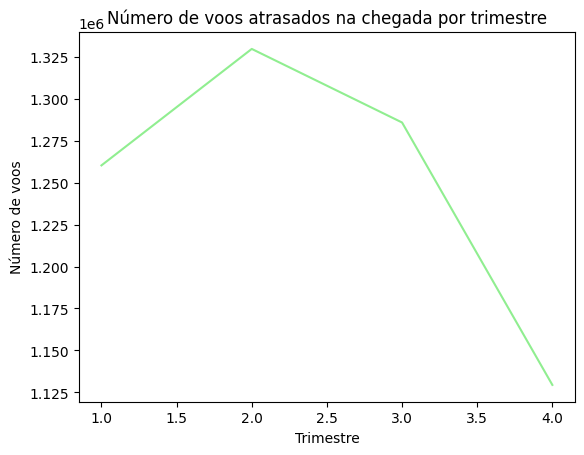

In [48]:
sns.lineplot(x='Quarter', y='Number of flights delayed', data=df_plot7, color='lightgreen')
plt.title('Número de voos atrasados na chegada por trimestre')
plt.xlabel('Trimestre')
plt.ylabel('Número de voos')
plt.show()

Nota-se um aumento crescente até ao segundo trimestre e um contínuo e progressivo decréscimo até ao quarto trimestre.

## Gráfico de barras com os voos atrasados na chegada por mês

In [49]:
sns.reset_defaults()

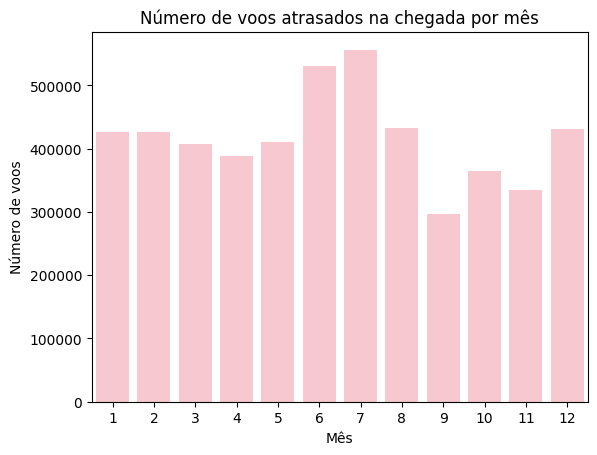

In [50]:
df_plot8 = ( df_arrdel15
           .groupBy('Month')
           .agg(F.count('*').alias('Number of flights delayed'))
           .sort('Month')
           .toPandas()
          )

sns.barplot(x='Month', y='Number of flights delayed', data=df_plot8, order=df_plot8['Month'], color='pink')
plt.xlabel('Mês')
plt.ylabel('Número de voos')
plt.title('Número de voos atrasados na chegada por mês')
plt.show()

O mês com maior número de voos atrasados por mês ocorre no mês 7 - julho -, seguido do mês 6 - junho. O menor valor ocorre no mês 9 - setembro.

## Time series com a evolução do número de voos atrasados na chegada por mês

In [51]:
sns.set(rc={'figure.figsize':(15,6)})

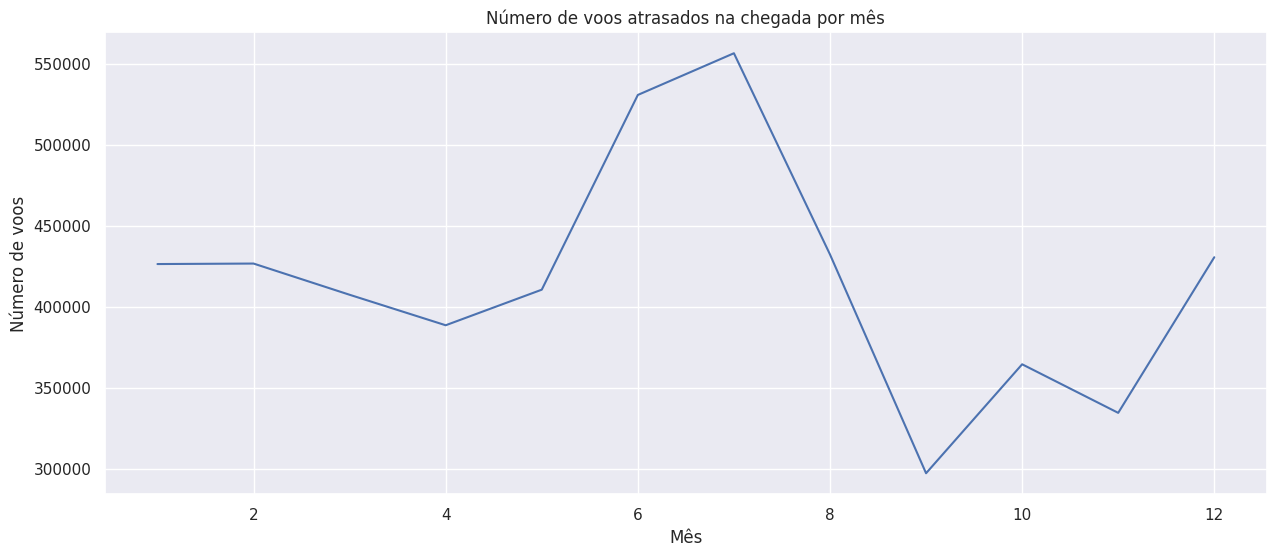

In [52]:
sns.lineplot(x='Month', y='Number of flights delayed', data=df_plot8)
plt.xlabel('Mês')
plt.ylabel('Número de voos')
plt.title('Número de voos atrasados na chegada por mês')
plt.show()

O número de voos atrasados na chegada mantem-se constante até fevereiro, diminui de forma suave até abril, aumenta primeiro de forma suave e depois de forma mais rápida até julho, decrescendo abruptamente até setembro, aumentando um pouco até outubro, decrescendo um pouco em novembro e voltando a aumentar em dezembro.

## Gráfico de barras com os voos atrasados na chegada por dia do mês

In [50]:
sns.set(rc={'figure.figsize':(15,6)})

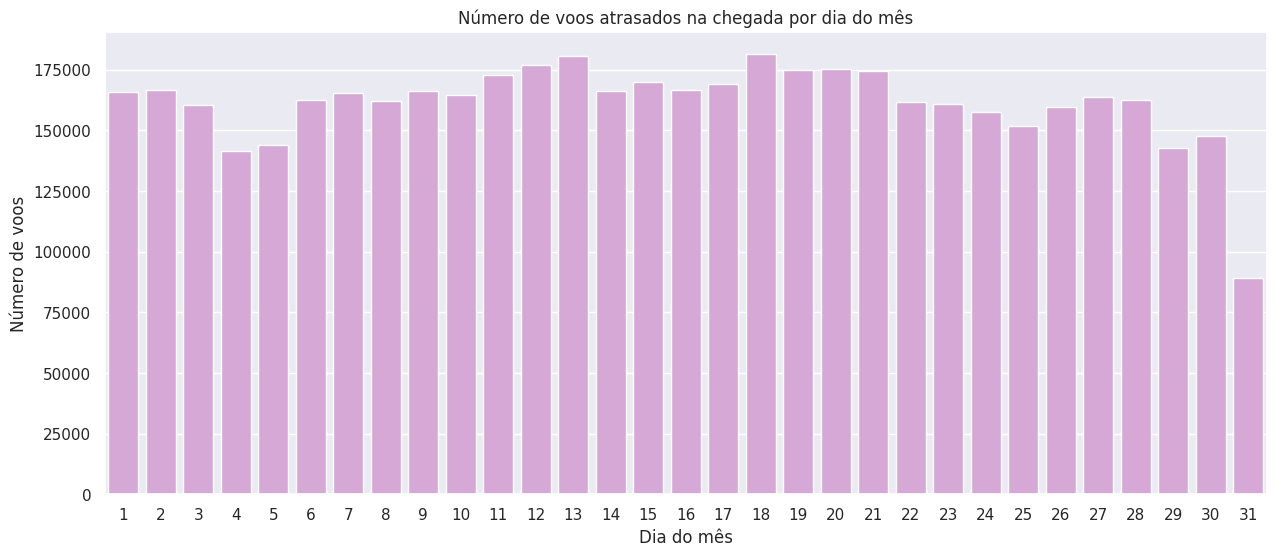

In [53]:
df_plot9 = ( df_arrdel15
           .groupBy('DayofMonth')
           .agg(F.count('*').alias('Number of flights delayed'))
           .sort('DayofMonth')
           .toPandas()
          )

sns.barplot(x='DayofMonth', y='Number of flights delayed', data=df_plot9, order=df_plot9['DayofMonth'], color='plum')
plt.xlabel('Dia do mês')
plt.ylabel('Número de voos')
plt.title('Número de voos atrasados na chegada por dia do mês')
#sns.set(rc={'figure.figsize':(15,6)})
plt.show()

Os dias do mês com mais atrasos na chegada são 18 e 13 e mais uma vez o com menos é 31.

## Time series com a evolução do número voos atrasados na chegada por dia do mês

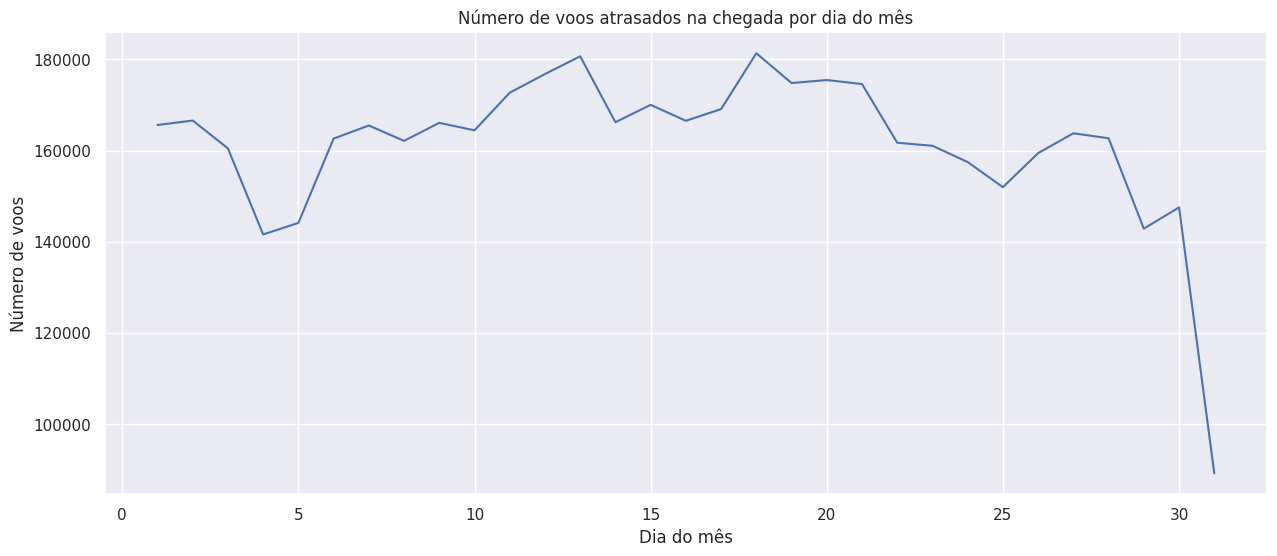

In [55]:
sns.lineplot(x='DayofMonth', y='Number of flights delayed', data=df_plot9)
plt.xlabel('Dia do mês')
plt.ylabel('Número de voos')
plt.title('Número de voos atrasados na chegada por dia do mês')
plt.show()

O número de voos atrasados na chegada começa por aumentar ligeiramente, decrescendo por volta do dia 4 e aumentando outra vez mantendo-se os valores relativamente constantes, ainda que existam os picos significativos entre os dias 10 e 15 e entre os dias 15 e 20. A partir de cerca do dia 22, o valor começa a descer, ainda que exista um pico nos dias 27 e 28, diminuindo significativamente a partir de dia 29.

## Gráfico de barras com os voos atrasados na chegada por dia da semana

In [56]:
sns.reset_defaults()

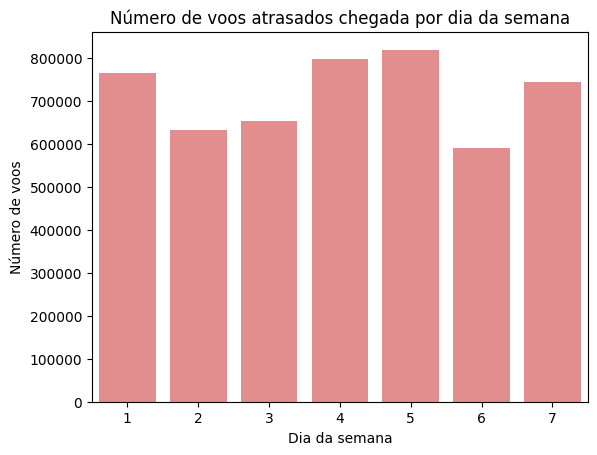

In [57]:
df_plot10 = ( df_arrdel15
           .groupBy('DayofWeek')
           .agg(F.count('*').alias('Number of flights delayed'))
           .sort('DayofWeek')
           .toPandas()
          )

sns.barplot(x='DayofWeek', y='Number of flights delayed', data=df_plot10, order=df_plot10['DayofWeek'], color='lightcoral')
plt.title('Número de voos atrasados chegada por dia da semana')
plt.xlabel('Dia da semana')
plt.ylabel('Número de voos')

plt.show()

O dia da semana com mais voos de chegada atrasados é 5 e o com menos é 6.

## Time series com a evolução do número de voos atrasados na chegada por dia da semana

In [59]:
sns.set(rc={'figure.figsize':(15,6)})

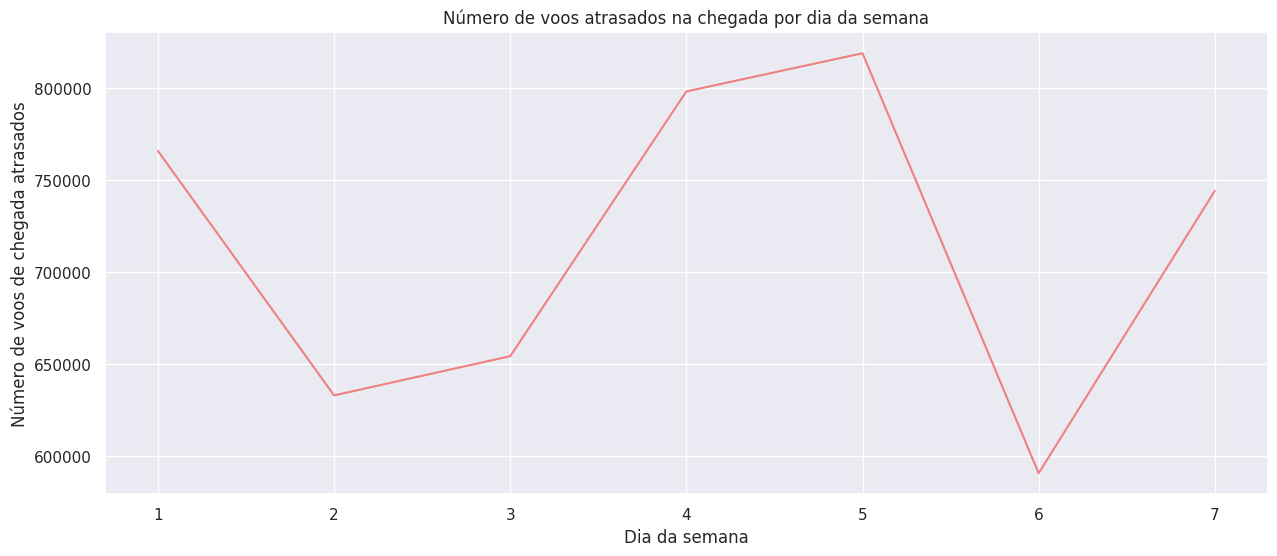

In [60]:
sns.lineplot(x='DayofWeek', y='Number of flights delayed', data=df_plot10, color='lightcoral')
plt.xlabel('Dia da semana')
plt.ylabel('Número de voos de chegada atrasados')
plt.title('Número de voos atrasados na chegada por dia da semana')
plt.show()

Existe um decréscimo suava no número de voos atrasado na chegada até ao dia da semana 2, até 3 a aumenta ligeiramente, aumentando bastante até 5, caindo a pique em 6 e aumentando bastante em 7.

## Gráfico circular com os voos atrasados na chegada

In [64]:
sns.reset_defaults()

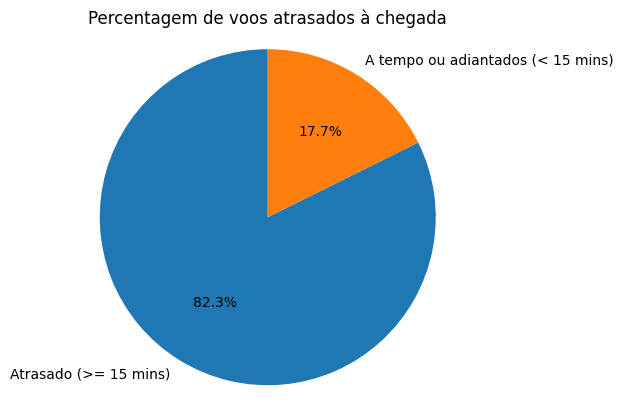

In [65]:
arrdel15_counts = df_flights_clean.groupBy('ArrDel15').count().collect()
counts = [row['count'] for row in arrdel15_counts]
labels = ['Atrasado (>= 15 mins)', 'A tempo ou adiantados (< 15 mins)']
fig, ax = plt.subplots()

ax.pie(counts, labels=labels, autopct='%1.1f%%', startangle=90)
ax.axis('equal')
plt.title('Percentagem de voos atrasados à chegada')

# Show the plot
plt.show()

A percentagem de voos atrasados à chegada é 82.3%, apenas 17.7% estão a tempo ou adiantados

# ----

## Gráfico circular com os estados dos voos de 2018 a 2022

23/04/04 15:15:32 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


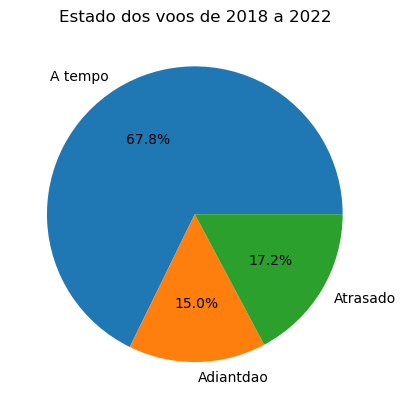

In [34]:
df_flights_clean.createOrReplaceTempView('flights')
flight_status = spark.sql("SELECT CASE WHEN DepDelayMinutes >= 15 THEN 'Atrasado' WHEN DepDelayMinutes = 0 THEN 'A tempo' ELSE 'Adiantdao' END AS FlightStatus, COUNT(*) AS FlightCount FROM flights WHERE Year BETWEEN 2018 AND 2022 GROUP BY FlightStatus").toPandas()

plt.pie(flight_status['FlightCount'], labels=flight_status['FlightStatus'], autopct='%1.1f%%')
plt.title('Estado dos voos de 2018 a 2022')
plt.show()

Considerando os voos de 2018 a 2022, 15.0% estão adiantados, 67.8% está a tempo e apenas 17.2% estão atrasados.

## Gráfico de barras com o top 10 de voos por destino 

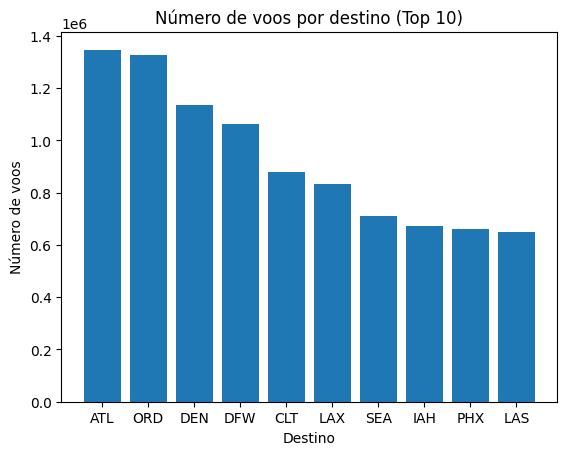

In [69]:
top_destinations = df_flights_clean.groupBy('Dest').count().orderBy(F.desc('count')).limit(10)

dest_names = [row[0] for row in top_destinations.collect()]
flight_counts = [row[1] for row in top_destinations.collect()]

plt.bar(dest_names, flight_counts)
plt.xlabel('Destino')
plt.ylabel('Número de voos')
plt.title('Número de voos por destino (Top 10)')
plt.show()

O Aeroporto Internacional de Atlanta Hartsfield-Jackson e Aeroporto Internacional O'Hare são os aeroportos mais comuns como destino

### Gráfico de barras top 10 de voos por origem

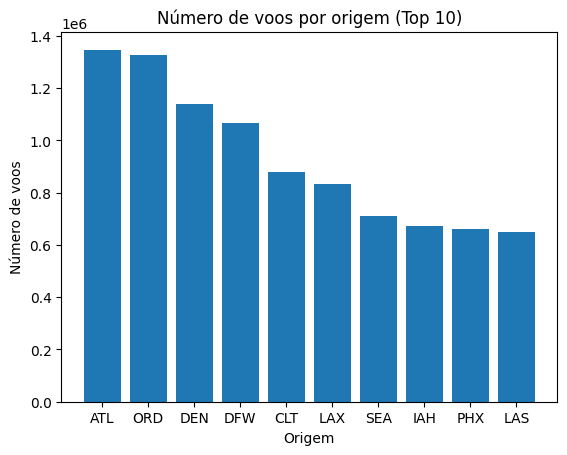

In [71]:
top_origins = df_flights_clean.groupBy('Origin').count().orderBy(F.desc('count')).limit(10)

origin_names = [row[0] for row in top_origins.collect()]
flight_counts = [row[1] for row in top_origins.collect()]

plt.bar(origin_names, flight_counts)
plt.xlabel('Origem')
plt.ylabel('Número de voos')
plt.title('Número de voos por origem (Top 10)')
plt.show()

O Aeroporto Internacional de Atlanta Hartsfield-Jackson e Aeroporto Internacional O'Hare são os aeroportos mais comuns como origem.

## Gráfico de barras com top 10 pares de origem destino

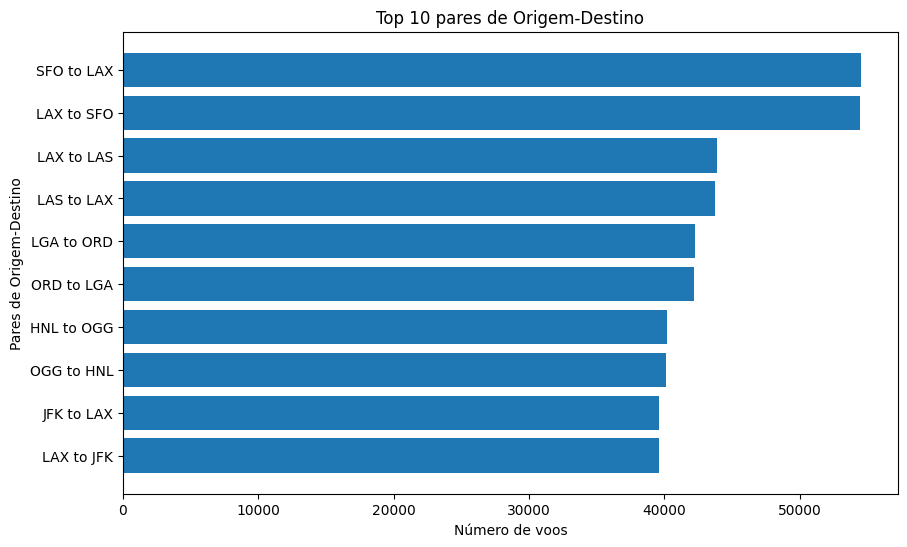

In [72]:
origin_dest_counts = df_flights_clean.groupBy('Origin', 'Dest').count()
top_10_origin_dest = origin_dest_counts.sort(desc('count')).limit(10)
top_10_origin_dest_pd = top_10_origin_dest.toPandas()
fig, ax = plt.subplots(figsize=(10, 6))

ax.barh(top_10_origin_dest_pd['Origin'] + ' to ' + top_10_origin_dest_pd['Dest'],
        top_10_origin_dest_pd['count'], align='center')
ax.set_xlabel('Número de voos')
ax.set_ylabel('Pares de Origem-Destino')
ax.set_title('Top 10 pares de Origem-Destino')
ax.invert_yaxis()
plt.show()

Os percursos mais frequentes partem do Aeroporto Internacional de São Francisco e vão para Aeroporto Internacional de Los Angeles e o contrário.

## Top 10 companhias aéreas com mais atrasos na partida

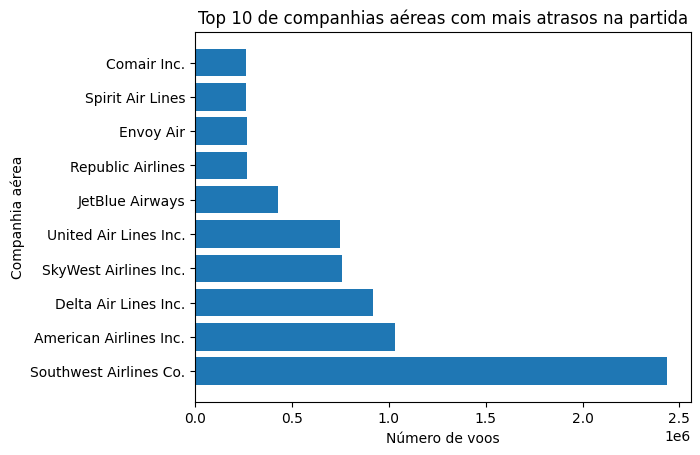

In [74]:
from pyspark.sql.functions import col

# Filter the flights that have a departure delay greater than 0
delayed_flights = df_flights_clean.filter(col('DepDelay') > 0)

# Group the resulting DataFrame by airline
grouped_flights = delayed_flights.groupBy('Airline')

# Aggregate the count of delayed flights for each airline
delay_count = grouped_flights.count()

# Sort the resulting DataFrame in descending order based on the count of delayed flights
sorted_delay_count = delay_count.orderBy('count', ascending=False)

# Select the top 10 airlines with the most delays
top_10_delays = sorted_delay_count.limit(10)

# Convert the resulting DataFrame to a Pandas DataFrame
pd_top_10_delays = top_10_delays.toPandas()

# Create a horizontal bar plot of the count of delayed flights for each airline
plt.barh(pd_top_10_delays['Airline'], pd_top_10_delays['count'])
plt.title('Top 10 de companhias aéreas com mais atrasos na partida')
plt.xlabel('Número de voos')
plt.ylabel('Companhia aérea')
plt.show()

A companhia aérea com mais atrasos na partida é Southwest Airlines.

## Gráfico de barras com o top 10 de companhias aéreas com mais atrasos na chegada

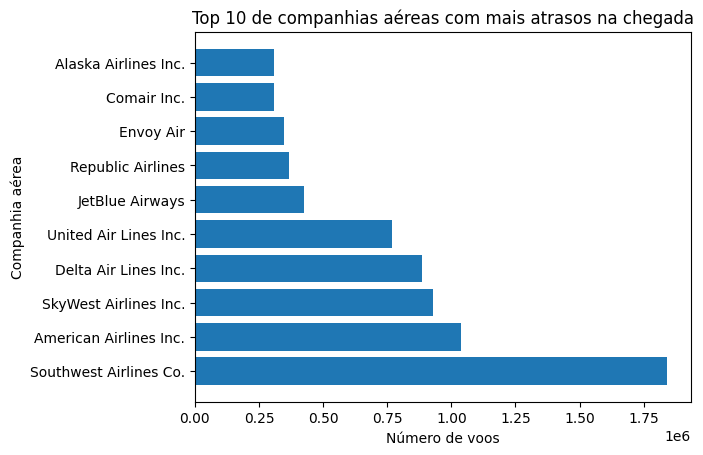

In [76]:
from pyspark.sql.functions import col

# Filter the flights that have a departure delay greater than 0
delayed_flights = df_flights_clean.filter(col('ArrDelay') > 0)

# Group the resulting DataFrame by airline
grouped_flights = delayed_flights.groupBy('Airline')

# Aggregate the count of delayed flights for each airline
delay_count = grouped_flights.count()

# Sort the resulting DataFrame in descending order based on the count of delayed flights
sorted_delay_count = delay_count.orderBy('count', ascending=False)

# Select the top 10 airlines with the most delays
top_10_delays = sorted_delay_count.limit(10)

# Convert the resulting DataFrame to a Pandas DataFrame
pd_top_10_delays = top_10_delays.toPandas()

# Create a horizontal bar plot of the count of delayed flights for each airline
plt.barh(pd_top_10_delays['Airline'], pd_top_10_delays['count'])
plt.title('Top 10 de companhias aéreas com mais atrasos na chegada')
plt.xlabel('Número de voos')
plt.ylabel('Companhia aérea')
plt.show()

A companhia aérea com mais atrasos na chegada é Southwest Airlines.

## Scatter plot com atrasos de partida vs atrasos de chegada

In [79]:
sns.reset_defaults()

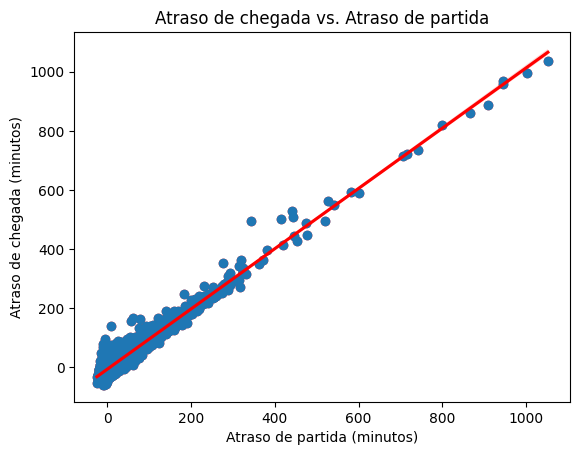

In [83]:
df_delays = df_flights_clean.select('DepDelay', 'ArrDelay').limit(10000).toPandas()

# plot the regression line in red
sns.regplot(data=df_delays, x='DepDelay', y='ArrDelay', color='red')

# plot the scatter plot with default color
plt.scatter(df_delays['DepDelay'], df_delays['ArrDelay'])

# set plot title and labels
plt.title('Atraso de chegada vs. Atraso de partida')
plt.xlabel('Atraso de partida (minutos)')
plt.ylabel('Atraso de chegada (minutos)')

# show the plot
plt.show()

Podemos ver que existe uma relação elevada entre os atrasos na chegada e partida.

## Histrograma com a distribuição do número de chegadas atrasadas em minutos

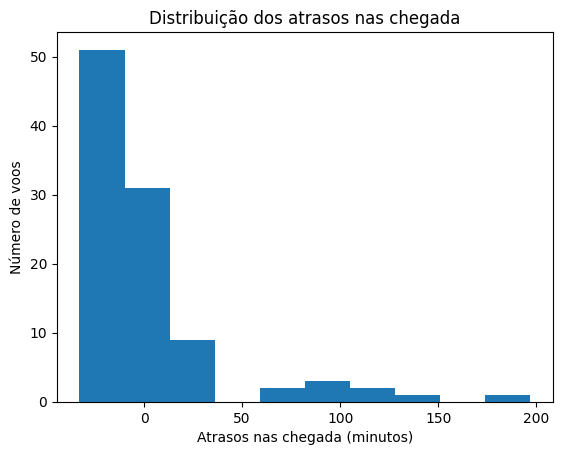

In [82]:
# Import necessary libraries
import matplotlib.pyplot as plt

# Create a Pandas DataFrame with the arrival delay column
df_arrival_delay = df_flights_clean.select('ArrDelay').limit(100).toPandas()

# Plot a histogram of arrival delays
plt.hist(df_arrival_delay['ArrDelay'], bins=10)
plt.xlabel('Atrasos nas chegada (minutos)')
plt.ylabel('Número de voos')
plt.title('Distribuição dos atrasos nas chegada')
plt.show()

A maioria dos atrasos são de menos de 45 minutos